## Technical Indicators in Modeling

### Initial imports

In [1]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from alpaca_trade_api.rest import REST, TimeFrame
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from pmdarima.arima import auto_arima
import alpaca_trade_api as tradeapi
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from datetime import datetime
import statsmodels.api as sm
from arch import arch_model
from datetime import date
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import sklearn
import getpass
load_dotenv()
import scipy
import os
sns.set()

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Technical Oscillator Class Import

In [3]:
from MACDBacktester import MACDBacktester as MACD
from SOBacktester import SOBacktester as SO
import SMABacktester as SMA

### Loading Alpaca API Key (even if you don't have it)

The below will load an Alpaca API key from an appropriately setup .env file. If not an user input box will open up asking it to be entered.  Note, the use of 'getpass' library will keep it private from eyes. Be WARNED, this does not mean it cant be 'printed' out.

In [4]:
# API Info for fetching data, portfolio, etc. from Alpaca
BASE_URL = "https://paper-api.alpaca.markets"

# if statement checking for .env file, if none found, a user input box will ask for the api key and api secret key.
# This will look like ' *************** ' when typed in
if os.getenv("APCA_API_KEY_ID") is not None:
    ALPACA_API_KEY = os.getenv("APCA_API_KEY_ID")
else:
    ALPACA_API_KEY = getpass.getpass('Type your alpaca api key here, it is safe from viewing.')
if os.getenv("ALPACA_SECRET_KEY") is not None:
    ALPACA_SECRET_KEY = os.getenv("ALPACA_SECRET_KEY")
else:
    ALPACA_SECRET_KEY = getpass.getpass('Type your secret alpaca api key here, it is safe from viewing.')

# Instantiate REST API Connection - Account
api_account = tradeapi.REST(key_id=ALPACA_API_KEY, secret_key=ALPACA_SECRET_KEY, raw_data=True,base_url=BASE_URL, api_version='v2')

# Instantiate REST API Connection - Trade
api_trade = tradeapi.REST(key_id=ALPACA_API_KEY, secret_key=ALPACA_SECRET_KEY, raw_data=False, base_url=BASE_URL, api_version='v2')

### Technical Strategies Overview

#### SMA Crossover Strategy

Crossovers indicating a moving average are generally the cause of breakouts and breakdowns. Moving averages can determine a change in the price trend based on the crossover. For example, a technique for trend reversal is using a five-period simple moving average along with a 15-period simple moving average (SMA). A crossover between the two will signal a reversal in trend, or a breakout or breakdown.

* In our SMA Strategy we will create a strategy to take a long position when the short term SMA crosses above the long term SMA. And go short when it crosses below the long term SMA.

Links:
https://www.investopedia.com/terms/c/crossover.asp

#### MACD Crossover Strategy

When the MACD falls below the signal line, it is a bearish signal that indicates that it may be time to sell. Conversely, when the MACD rises above the signal line, the indicator gives a bullish signal, which suggests that the price of the asset is likely to experience upward momentum. Some traders wait for a confirmed cross above the signal line before entering a position to reduce the chances of being "faked out" and entering a position too early.

Our strategy will assume exactly this, when MACD crosses below the signal line, take a short position, when it crosses above, take a long position.

Links: https://www.investopedia.com/terms/m/macd.asp

#### SO Crossover Strategy

The Formula for the Stochastic Oscillator Is
\begin{aligned} &\text{%K}=\left(\frac{\text{C} - \text{L14}}{\text{H14} - \text{L14}}\right)\times100\\ &\textbf{where:}\\ &\text{C = The most recent closing price}\\ &\text{L14 = The lowest price traded of the 14 previous}\\ &\text{trading sessions}\\ &\text{H14 = The highest price traded during the same}\\ &\text{14-day period}\\ &\text{%K = The current value of the stochastic indicator}\\ \end{aligned} 

Notably, %K is referred to sometimes as the fast stochastic indicator. The "slow" stochastic indicator is taken as %D = 3-period moving average of %K.

One stochastic oscillator strategy consists of two lines: one reflecting the actual value of the oscillator for each session, and one reflecting its three-day simple moving average. Because price is thought to follow momentum, the intersection of these two lines is considered to be a signal that a reversal may be in the works, as it indicates a large shift in momentum from day to day.

Our strategy will go long when %K (fast indicator) crosses above %D (short indicator), and go short when crossing below

Links: https://www.investopedia.com/terms/s/stochasticoscillator.asp

### Enter Parameters for Strategies

#### Shared Parameters

In [5]:
# Choose a symbol
symbol = 'BTCUSD'

In [6]:
# Get the start date and end dates
start = "2009-01-03" # Bitcoin's genesis block date, we wont get all data limited by alpaca
end = datetime.today().strftime('%Y-%m-%d')

#### SMA Parameters

In [7]:
# choose your short term and long term SMA Windows
SMA_S = 50
SMA_L = 200

#### MACD Parameters

In [8]:
# time window in days for shorter EMA
ema_s = 12

# time window in days for longer EMA
ema_l = 26

# time window is days for MACD Signal 
signal_mw = 9

# proportional transaction costs per trade, you could assume an average cost of each coin 
# or gas fees such as on the Ethereum blockchain 
# Gas fees are the the reward given to miners for putting transactions in the blockchain or executing them
# Here we will keep them at 0 for simplicity

tc = 0.00000 

#### SO parameters 

In [9]:
# time window in days for rolling low/high
periods = 14

# time window in days for %D line
d_mw = 3

### Instantiating Custom Classes

Instantiating a class is creating a copy of the class which inherits all class variables and methods. Instantiating a class in Python is simple. To instantiate a class, we simply call the class as if it were a function, passing the arguments that the '__init__' method defines.

In [10]:
#  def __init__(self, symbol, SMA_S, SMA_L, start, end, api):
sma = SMA.SMABacktester(symbol, SMA_S, SMA_L, start, end, api_trade)

# def __init__(self, symbol, periods, D_mw, start, end, tc, api):
so = SO(symbol, periods, d_mw, start, end, tc,api_trade)

# def __init__(self, symbol, EMA_S, EMA_L, signal_mw, start, end, tc, api):
macd = MACD(symbol, EMA_S = ema_s, EMA_L = ema_l, signal_mw = signal_mw, start = start, end = end, tc = tc,api=api_trade)

### Optimization

The 'brute' force optimizer minimizes a function over a given range by brute force. Uses the “brute force” method, i.e., computes the function’s value at each point of a multidimensional grid of points, to find the global minimum of the function.

The function is evaluated everywhere in the range with the datatype of the first call to the function, as enforced by the vectorize NumPy function. The value and type of the function evaluation returned when full_output=True are affected in addition by the finish argument.

[The brute force approach is inefficient because the number of grid points increases exponentially - the number of grid points to evaluate is Ns ** len(x). Consequently, even with coarse grid spacing, even moderately sized problems can take a long time to run, and/or run into memory limitations.](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.brute.html)

We will leverage the power of brute force by finding the global maximum of returns by testing all possible parameters passed in, and we will be finding the global maximum specifically of returns generated.  Recall, no costs are being assumed.

Within each class, an  optimize_parameters function can be found. The essence of what is happening, say for the sma.optimize_parameters is for the short window between 25-50 and long window between 100-200 by brute force, we will find the combo that generate maximum returns, by stepping through each combination by incrementing between the range by 1

The output will be a list, the short window and long window, followed by a number, the cumulative return of what what be earned for every $1 dollar invested.

In [11]:
# SMA Strategy
sma.optimize_parameters((25, 50, 1), (100, 200, 1)) # optimizing strategy & backtesting ("in-sample")

(array([ 37., 102.]), 220.37893)

In [12]:
# Stochastic Oscillator Strategy
so.optimize_parameters((10, 100, 1), (3, 50, 1))

(array([94., 14.]), 977.97545)

In [13]:
# MACD Strategy 
macd.optimize_parameters((5, 20, 1), (21, 50, 1), (5, 20, 1))

(array([12., 24., 19.]), 657.591613)

### Plotting the results

Each class also has a plot results function to plot the Cumulative Returns vs a 'Buy and Hold Strategy'

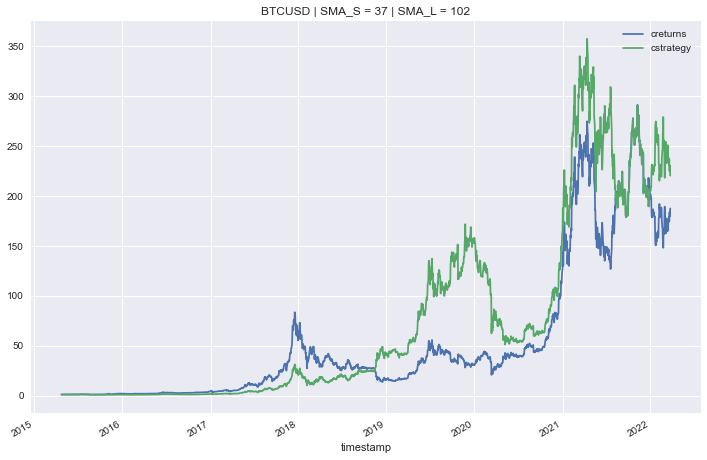

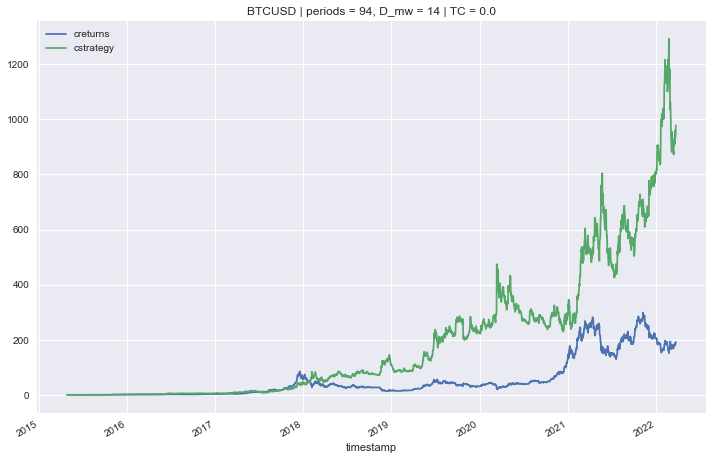

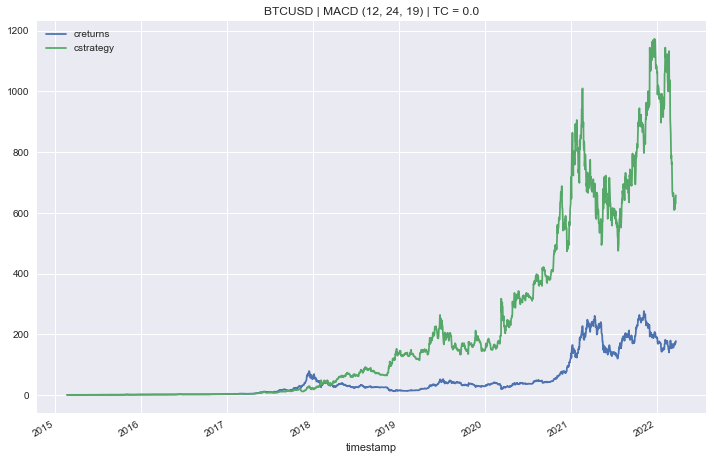

In [14]:
sma.plot_results()
so.plot_results()
macd.plot_results()

#### Review the Data Frame

Once a strategy is tested, the function def test_strategy stores the data within 'self.results = data'

In [15]:
# View SMA results as a dataframe
sma.results
sma_df= pd.DataFrame(sma.results)
sma_df

,close,returns,SMA_S,SMA_L,position,strategy,creturns,cstrategy
timestamp,,,,,,,,
2015-04-23 05:00:00+00:00,233.89,-0.000385,244.463784,245.640196,-1,0.000385,0.999615,1.000385
2015-04-24 05:00:00+00:00,230.39,-0.015077,243.767297,245.065686,-1,0.015077,0.984657,1.015582
2015-04-25 05:00:00+00:00,220.58,-0.043513,242.585405,244.679216,-1,0.043513,0.942730,1.060749
2015-04-26 05:00:00+00:00,220.14,-0.001997,241.418649,244.684216,-1,0.001997,0.940850,1.062869
2015-04-27 05:00:00+00:00,227.58,0.033238,240.491081,245.738922,-1,-0.033238,0.972647,1.028122
...,...,...,...,...,...,...,...,...
2022-03-20 05:00:00+00:00,40882.31,-0.024003,40171.084324,42388.091863,-1,0.024003,174.725660,236.518025
2022-03-21 05:00:00+00:00,43001.23,0.050531,40190.222973,42336.489902,-1,-0.050531,183.781648,224.863410
2022-03-22 05:00:00+00:00,41963.89,-0.024419,40194.972162,42273.884902,-1,0.024419,179.348192,230.421994


In [16]:
# View SO results as a dataframe
so.results
so_df = pd.DataFrame(so.results)
so_df

,exchange,open,high,low,close,volume,trade_count,vwap,returns,roll_low,roll_high,K,D,position,strategy,trades,creturns,cstrategy
timestamp,,,,,,,,,,,,,,,,,,
2015-04-28 05:00:00+00:00,CBSE,225.69,227.55,220.46,225.64,5240.441591,8855,224.568781,-0.008561,216.16,322.72,8.896396,28.766981,-1,0.008561,0.0,0.991476,1.008598
2015-04-29 05:00:00+00:00,CBSE,225.78,227.05,225.10,226.46,1811.528904,3036,225.710251,0.003628,216.16,322.72,9.665916,25.615664,-1,-0.003628,0.0,0.995079,1.004946
2015-04-30 05:00:00+00:00,CBSE,236.78,238.78,235.66,236.52,1735.885889,4697,237.266107,0.043464,216.16,297.45,25.046131,23.399841,1,-0.043464,2.0,1.039283,0.962202
2015-05-01 05:00:00+00:00,CBSE,236.61,238.45,233.01,233.14,8233.330242,20257,235.457570,-0.014394,216.16,297.45,20.888178,21.074611,-1,-0.014394,2.0,1.024431,0.948452
2015-05-02 05:00:00+00:00,CBSE,235.94,237.51,234.26,236.63,1160.867237,2666,235.843926,0.014859,216.16,297.45,25.181449,19.033896,1,-0.014859,2.0,1.039766,0.934463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-20 05:00:00+00:00,CBSE,41875.01,42037.81,40509.00,40882.31,7447.710197,424873,41304.396200,-0.024003,32933.33,52025.00,41.635855,36.730484,1,-0.024003,0.0,179.639292,911.242105
2022-03-21 05:00:00+00:00,CBSE,40886.69,43389.79,40750.07,43001.23,15151.832790,579895,41465.597475,0.050531,32933.33,52025.00,52.734517,38.470061,1,0.050531,0.0,188.949952,958.471558
2022-03-22 05:00:00+00:00,CBSE,42268.14,43239.61,41766.79,41963.89,13845.719338,511776,42633.738855,-0.024419,32933.33,52025.00,47.301048,38.634366,1,-0.024419,0.0,184.391818,935.349873


In [17]:
# View MACD results as a dataframe
macd.results
macd_df = pd.DataFrame(macd.results)
macd_df

,close,returns,EMA_S,EMA_L,MACD,MACD_Signal,position,strategy,trades,creturns,cstrategy
timestamp,,,,,,,,,,,
2015-02-22 06:00:00+00:00,237.65,-0.035792,239.388262,236.553983,2.834279,1.101619,1,-0.035792,0.0,0.964841,0.964841
2015-02-23 06:00:00+00:00,239.19,0.006459,239.357741,236.770385,2.587356,1.268447,1,0.006459,0.0,0.971093,0.971093
2015-02-24 06:00:00+00:00,239.46,0.001128,239.373482,236.990724,2.382757,1.392050,1,0.001128,0.0,0.972190,0.972190
2015-02-25 06:00:00+00:00,237.50,-0.008219,239.085121,237.032365,2.052756,1.464546,1,-0.008219,0.0,0.964232,0.964232
2015-02-26 06:00:00+00:00,237.11,-0.001643,238.781138,237.038702,1.742436,1.494744,1,-0.001643,0.0,0.962649,0.962649
...,...,...,...,...,...,...,...,...,...,...,...
2022-03-20 05:00:00+00:00,40882.31,-0.024003,40441.025669,40216.792972,224.232697,-124.353879,1,-0.024003,0.0,165.979091,612.720049
2022-03-21 05:00:00+00:00,43001.23,0.050531,40834.903259,40439.547934,395.355325,-72.382959,1,0.050531,0.0,174.581747,644.477177
2022-03-22 05:00:00+00:00,41963.89,-0.024419,41008.593527,40561.495299,447.098227,-20.434840,1,-0.024419,0.0,170.370225,628.930134


### Backtesting & Forward Testing

#### Training Set

In [18]:
# Lets train and optimize our parameters for only the beginning of 2019 to the end of 2020 on the SMA strategy
train_sma = SMA.SMABacktester(symbol, 50, 200, "2019-01-01", "2020-12-31",api_trade)

In [19]:
train_sma.optimize_parameters((25, 50, 1), (100, 200, 1)) # optimizing strategy & backtesting ("in-sample")

(array([ 33., 105.]), 3.552848)

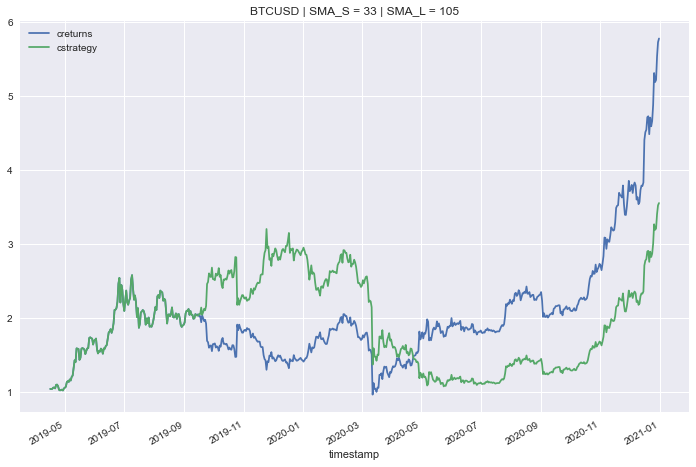

In [20]:
train_sma.plot_results()

### Test set

In [21]:
# Use the hyper parameters to see if the model that potentially minimized 
# our downside without any stop loss is a winning future strategy
tester_sma = SMA.SMABacktester(symbol, 33, 105, "2021-01-01", end, api_trade)

In [22]:
# Test the strategy, or an error is returned
# the outperformance / underperformance in an array
tester_sma.test_strategy() #("in-sample")

(0.568574, -0.910657)

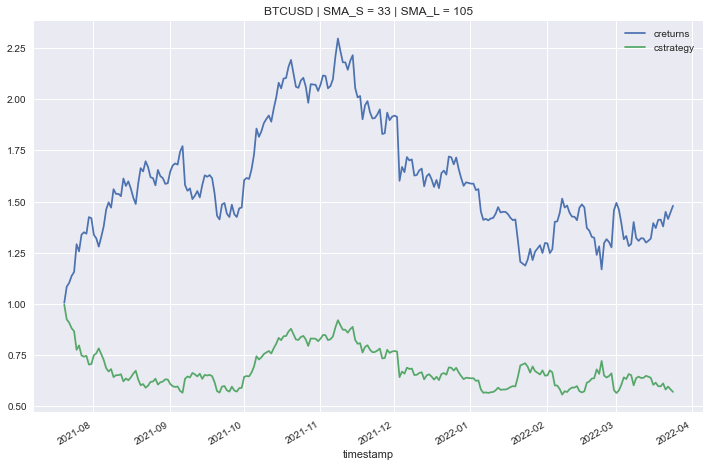

In [23]:
tester_sma.plot_results()

####  Repeating the same with the other 2 strategies

(array([19., 34., 19.]), 9.936117)

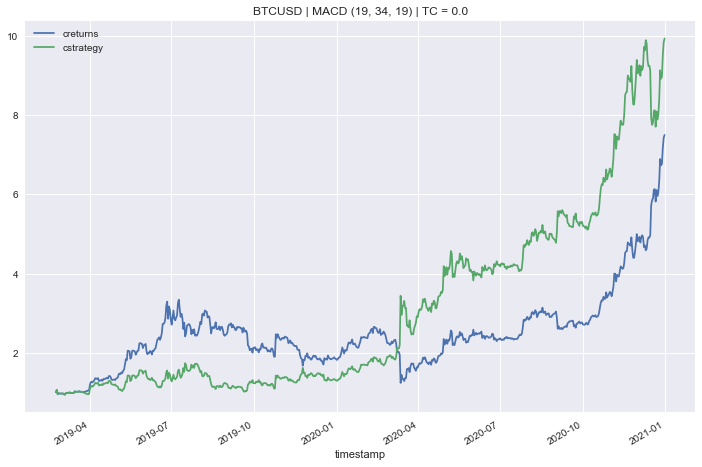

In [24]:
train_macd = MACD(symbol, EMA_S = ema_s, EMA_L = ema_l, signal_mw = signal_mw,
               start = "2019-01-01", end = "2020-12-31", tc = tc,api=api_trade)
train_macd.test_strategy()
display(train_macd.optimize_parameters((5, 20, 1), (21, 50, 1), (5, 20, 1)))
train_macd.plot_results()

(0.446241, -0.338599)

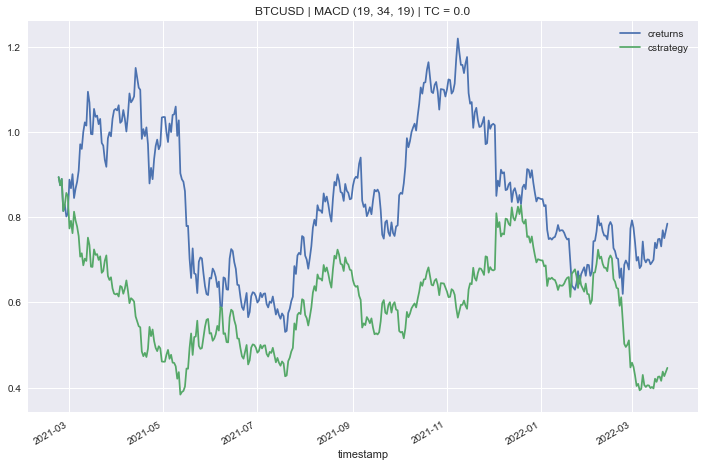

In [25]:
tester_macd = MACD(symbol, EMA_S = 19, EMA_L = 34, signal_mw = 19,start = "2021-01-01", end = end,
                   tc = tc,api=api_trade)

# The test_strategy function will output the cumulative return of $1 dollar invested
display(tester_macd.test_strategy()) # forward testing ("out-sample")
tester_macd.plot_results()

(array([56., 14.]), 5.201904)

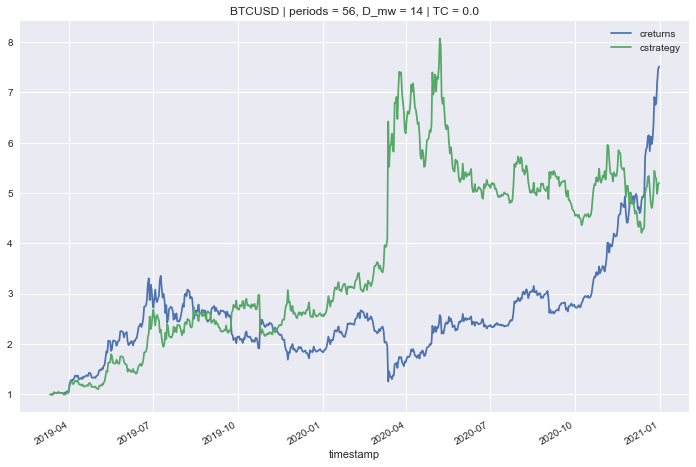

In [26]:
train_SO = SO(symbol, periods, d_mw,"2019-01-01","2020-12-31",tc,api_trade)
train_SO.test_strategy()
display(train_SO.optimize_parameters((10, 100, 1), (3, 50, 1)))
train_SO.plot_results()

(1.187295, 0.402924)

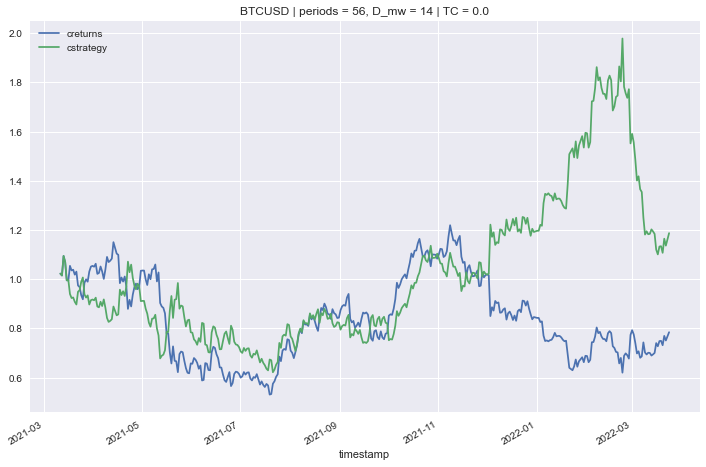

In [27]:
tester_SO = SO(symbol, 56, 14,"2021-01-01",end,tc,api_trade)

# The test_strategy function will output the cumulative return of $1 dollar invested
display(tester_SO.test_strategy()) # forward testing ("out-sample")
tester_SO.plot_results()

#### First Conclusion

In [28]:
# SO Strategy
tester_SO.test_strategy()

(1.187295, 0.402924)

In [29]:
# MACD Strategy
tester_macd.test_strategy()

(0.446241, -0.338599)

In [30]:
# SMA Strategy
tester_sma.test_strategy()

(0.568574, -0.910657)

Reviewing the test results, over time, the strategy can provide results that would under perform the market in certain strategies (such as MACD, AND SMA, and outperform such as in the SO, therefore:

1) Utilizing a technical strategy could beat a buy and hold strategy
2) However, the strategy should be updated and optimized
3) It may be considered to combine strategies for more true signals, or potentially updating periodically to find the strategy that minimizes downside, or build a function to minimize downside itself to preserve capital

In [31]:
#Now with the data
macd_df

,close,returns,EMA_S,EMA_L,MACD,MACD_Signal,position,strategy,trades,creturns,cstrategy
timestamp,,,,,,,,,,,
2015-02-22 06:00:00+00:00,237.65,-0.035792,239.388262,236.553983,2.834279,1.101619,1,-0.035792,0.0,0.964841,0.964841
2015-02-23 06:00:00+00:00,239.19,0.006459,239.357741,236.770385,2.587356,1.268447,1,0.006459,0.0,0.971093,0.971093
2015-02-24 06:00:00+00:00,239.46,0.001128,239.373482,236.990724,2.382757,1.392050,1,0.001128,0.0,0.972190,0.972190
2015-02-25 06:00:00+00:00,237.50,-0.008219,239.085121,237.032365,2.052756,1.464546,1,-0.008219,0.0,0.964232,0.964232
2015-02-26 06:00:00+00:00,237.11,-0.001643,238.781138,237.038702,1.742436,1.494744,1,-0.001643,0.0,0.962649,0.962649
...,...,...,...,...,...,...,...,...,...,...,...
2022-03-20 05:00:00+00:00,40882.31,-0.024003,40441.025669,40216.792972,224.232697,-124.353879,1,-0.024003,0.0,165.979091,612.720049
2022-03-21 05:00:00+00:00,43001.23,0.050531,40834.903259,40439.547934,395.355325,-72.382959,1,0.050531,0.0,174.581747,644.477177
2022-03-22 05:00:00+00:00,41963.89,-0.024419,41008.593527,40561.495299,447.098227,-20.434840,1,-0.024419,0.0,170.370225,628.930134


In [32]:
# Creating a technical indicator feature set that includes the close price
macd_feat = macd_df[['close','EMA_S','EMA_L','MACD','MACD_Signal']]
so_feat = so_df[['vwap','K','D']]
sma_feat = sma_df[['SMA_L','SMA_S']]

In [33]:
dfc = pd.concat((macd_feat,so_feat,sma_feat), axis=1)
dfc = dfc.dropna()
dfc

,close,EMA_S,EMA_L,MACD,MACD_Signal,vwap,K,D,SMA_L,SMA_S
timestamp,,,,,,,,,,
2015-04-28 05:00:00+00:00,225.64,227.967433,233.214718,-5.247285,-5.654603,224.568781,8.896396,28.766981,245.948922,239.311081
2015-04-29 05:00:00+00:00,226.46,227.735520,232.674279,-4.938759,-5.583010,225.710251,9.665916,25.615664,246.213627,238.201081
2015-04-30 05:00:00+00:00,236.52,229.086978,232.981969,-3.894990,-5.414191,237.266107,25.046131,23.399841,246.728529,237.878378
2015-05-01 05:00:00+00:00,233.14,229.710520,232.994612,-3.284092,-5.201161,235.457570,20.888178,21.074611,246.803333,237.537838
2015-05-02 05:00:00+00:00,236.63,230.775056,233.285469,-2.510414,-4.932063,235.843926,25.181449,19.033896,246.985980,237.207568
...,...,...,...,...,...,...,...,...,...,...
2022-03-20 05:00:00+00:00,40882.31,40441.025669,40216.792972,224.232697,-124.353879,41304.396200,41.635855,36.730484,42388.091863,40171.084324
2022-03-21 05:00:00+00:00,43001.23,40834.903259,40439.547934,395.355325,-72.382959,41465.597475,52.734517,38.470061,42336.489902,40190.222973
2022-03-22 05:00:00+00:00,41963.89,41008.593527,40561.495299,447.098227,-20.434840,42633.738855,47.301048,38.634366,42273.884902,40194.972162


### Loading / Fetching Stock,Ethereum (ETHUSD) and litecoin (LTCUSD) close prices as well as BTC Has Rate data

In [34]:
# Filter for the close, send to da dataframe, and convert the datetime index

# Ethereum (ETHUSD)
eth_df = api_trade.get_crypto_bars('ETHUSD', TimeFrame.Day, "2016-08-16", "2022-06-09", exchanges=['CBSE']).df
eth_df = eth_df['close']
eth_df = eth_df.to_frame(name='ETH')
eth_df.index = pd.to_datetime(eth_df.index, format = '%m/%d/%Y').strftime('%Y-%m-%d')
eth_df.index = pd.to_datetime(eth_df.index)

# litecoin (LTCUSD)
ltc_df = api_trade.get_crypto_bars('LTCUSD', TimeFrame.Day, "2016-08-16", "2022-06-09", exchanges=['CBSE']).df
ltc_df = ltc_df['close']
ltc_df = ltc_df.to_frame(name='LTC')
ltc_df.index = pd.to_datetime(ltc_df.index, format = '%m/%d/%Y').strftime('%Y-%m-%d')
ltc_df.index = pd.to_datetime(ltc_df.index)

In [35]:
# Why arbitratry date, only limiitations when requesteing daily data (Litecoin data via coinbase [CBSE] goes back to 2016-08-16
# Get the start date
start = "2009-01-03" # Bitcoin's genesis block date, we wont get all data limited by alpaca

# Ethereum (ETHUSD)
eth_x = api_trade.get_crypto_bars('ETHUSD', TimeFrame.Day, start, "2022-06-09", exchanges=['CBSE']).df
eth_x = eth_x['close']
eth_x = eth_x.to_frame(name='ETH')
eth_x.index = pd.to_datetime(eth_x.index, format = '%m/%d/%Y').strftime('%Y-%m-%d')
eth_x.index = pd.to_datetime(eth_x.index)

# litecoin (LTCUSD)
ltc_x = api_trade.get_crypto_bars('LTCUSD', TimeFrame.Day, start, "2022-06-09", exchanges=['CBSE']).df
ltc_x = ltc_x['close']
ltc_x = ltc_x.to_frame(name='LTC')
ltc_x.index = pd.to_datetime(ltc_x.index, format = '%m/%d/%Y').strftime('%Y-%m-%d')
ltc_x.index = pd.to_datetime(ltc_x.index)

In [36]:
# View Dataframes
display(eth_x)
display(ltc_x)

,ETH
timestamp,
2016-05-17,14.00
2016-05-18,13.18
2016-05-19,14.82
2016-05-20,14.17
2016-05-23,13.74
...,...
2022-03-20,2847.32
2022-03-21,3028.52
2022-03-22,2939.32


,LTC
timestamp,
2016-08-16,3.70
2016-08-17,3.62
2016-08-18,3.70
2016-08-19,3.75
2016-08-21,4.00
...,...
2022-03-20,114.44
2022-03-21,120.12
2022-03-22,119.81


In [37]:
# View Dataframes
display(eth_df)
display(ltc_df)

,ETH
timestamp,
2016-08-16,11.18
2016-08-17,10.93
2016-08-18,10.80
2016-08-19,11.07
2016-08-20,11.30
...,...
2022-03-20,2847.32
2022-03-21,3028.52
2022-03-22,2939.32


,LTC
timestamp,
2016-08-16,3.70
2016-08-17,3.62
2016-08-18,3.70
2016-08-19,3.75
2016-08-21,4.00
...,...
2022-03-20,114.44
2022-03-21,120.12
2022-03-22,119.81


In [38]:
# Load in bitcoin hash rate data
hr_data = pd.read_csv("hash-rate.csv", parse_dates = ["Date"], index_col = "Date")
# Check if the type of date type index is datetime64
hr_data.index.inferred_type == "datetime64"

True

In [39]:
# Filter to 8/16/2016, this is due to data limitations in Alpaca API, and for the latest date available when utilizing the API
hr_data = hr_data["2016-08-16":]

In [40]:
# View Has Rate data
hr_data

,TH/s
Date,
2016-08-16,1.469588e+06
2016-08-17,1.329113e+06
2016-08-18,1.664092e+06
2016-08-19,1.664092e+06
2016-08-20,1.685704e+06
...,...
2022-03-17,2.175230e+08
2022-03-18,1.951495e+08
2022-03-19,2.115256e+08


In [41]:
# Pull in Nvidia data
nvda = pd.read_csv("NVDA.csv", parse_dates = ["Date"], index_col = "Date")
nvda = nvda["2016-08-16":]
nvda

,NVDA
Date,
2016-08-16,15.650000
2016-08-17,15.287500
2016-08-18,15.525000
2016-08-19,15.565000
2016-08-22,15.630000
...,...
2022-03-15,229.729996
2022-03-16,244.960007
2022-03-17,247.660004


### Cleaning the data

In [42]:
# Convert the index from a timestampe to datetime index
dfc.index = pd.to_datetime(dfc.index, format = '%m/%d/%Y').strftime('%Y-%m-%d')
dfc

,close,EMA_S,EMA_L,MACD,MACD_Signal,vwap,K,D,SMA_L,SMA_S
timestamp,,,,,,,,,,
2015-04-28,225.64,227.967433,233.214718,-5.247285,-5.654603,224.568781,8.896396,28.766981,245.948922,239.311081
2015-04-29,226.46,227.735520,232.674279,-4.938759,-5.583010,225.710251,9.665916,25.615664,246.213627,238.201081
2015-04-30,236.52,229.086978,232.981969,-3.894990,-5.414191,237.266107,25.046131,23.399841,246.728529,237.878378
2015-05-01,233.14,229.710520,232.994612,-3.284092,-5.201161,235.457570,20.888178,21.074611,246.803333,237.537838
2015-05-02,236.63,230.775056,233.285469,-2.510414,-4.932063,235.843926,25.181449,19.033896,246.985980,237.207568
...,...,...,...,...,...,...,...,...,...,...
2022-03-20,40882.31,40441.025669,40216.792972,224.232697,-124.353879,41304.396200,41.635855,36.730484,42388.091863,40171.084324
2022-03-21,43001.23,40834.903259,40439.547934,395.355325,-72.382959,41465.597475,52.734517,38.470061,42336.489902,40190.222973
2022-03-22,41963.89,41008.593527,40561.495299,447.098227,-20.434840,42633.738855,47.301048,38.634366,42273.884902,40194.972162


In [43]:
# All index types should be datetime64 to concat correctly, the dfs dataframe is not in the correct format
display(dfc.index.inferred_type == "datetime64")
display(hr_data.index.inferred_type == "datetime64")
display(nvda.index.inferred_type == "datetime64")

False

True

True

In [44]:
# Use to_datetime to change the format to match our other dataframes
dfc.index = pd.to_datetime(dfc.index)
display(dfc.index.inferred_type == "datetime64")

True

In [45]:
dfc

,close,EMA_S,EMA_L,MACD,MACD_Signal,vwap,K,D,SMA_L,SMA_S
timestamp,,,,,,,,,,
2015-04-28,225.64,227.967433,233.214718,-5.247285,-5.654603,224.568781,8.896396,28.766981,245.948922,239.311081
2015-04-29,226.46,227.735520,232.674279,-4.938759,-5.583010,225.710251,9.665916,25.615664,246.213627,238.201081
2015-04-30,236.52,229.086978,232.981969,-3.894990,-5.414191,237.266107,25.046131,23.399841,246.728529,237.878378
2015-05-01,233.14,229.710520,232.994612,-3.284092,-5.201161,235.457570,20.888178,21.074611,246.803333,237.537838
2015-05-02,236.63,230.775056,233.285469,-2.510414,-4.932063,235.843926,25.181449,19.033896,246.985980,237.207568
...,...,...,...,...,...,...,...,...,...,...
2022-03-20,40882.31,40441.025669,40216.792972,224.232697,-124.353879,41304.396200,41.635855,36.730484,42388.091863,40171.084324
2022-03-21,43001.23,40834.903259,40439.547934,395.355325,-72.382959,41465.597475,52.734517,38.470061,42336.489902,40190.222973
2022-03-22,41963.89,41008.593527,40561.495299,447.098227,-20.434840,42633.738855,47.301048,38.634366,42273.884902,40194.972162


In [46]:
# Filter to 8/16/2016, this is due to data limitations in Alpaca API, and for the latest date available when utilizing the API
dfc = dfc["2016-08-16":]
dfc

,close,EMA_S,EMA_L,MACD,MACD_Signal,vwap,K,D,SMA_L,SMA_S
timestamp,,,,,,,,,,
2016-08-16,579.02,586.021449,601.881782,-15.860333,-13.328243,575.255791,41.842566,43.333611,598.307353,626.632973
2016-08-17,574.46,584.242764,599.688039,-15.445275,-13.539946,574.604827,40.513120,43.356518,599.410784,624.600000
2016-08-18,575.06,582.830031,597.717796,-14.887765,-13.674728,574.628338,40.688047,43.097459,600.521569,622.181892
2016-08-19,573.67,581.420796,595.793972,-14.373177,-13.744573,574.987659,40.282799,42.903165,601.595196,620.022162
2016-08-20,582.16,581.534519,594.703254,-13.168735,-13.686989,582.043909,42.758017,42.681799,602.827745,617.756757
...,...,...,...,...,...,...,...,...,...,...
2022-03-20,40882.31,40441.025669,40216.792972,224.232697,-124.353879,41304.396200,41.635855,36.730484,42388.091863,40171.084324
2022-03-21,43001.23,40834.903259,40439.547934,395.355325,-72.382959,41465.597475,52.734517,38.470061,42336.489902,40190.222973
2022-03-22,41963.89,41008.593527,40561.495299,447.098227,-20.434840,42633.738855,47.301048,38.634366,42273.884902,40194.972162


In [47]:
# Check if there are any NaN 
display(dfc.isna().sum())
display(nvda.isna().sum())
display(eth_df.isna().sum())
display(ltc_df.isna().sum())

close          0
EMA_S          0
EMA_L          0
MACD           0
MACD_Signal    0
vwap           0
K              0
D              0
SMA_L          0
SMA_S          0
dtype: int64

NVDA    0
dtype: int64

ETH    0
dtype: int64

LTC    0
dtype: int64

In [48]:
# All index types should be datetime64 to concat correctly, the dfs dataframe is not in the correct format
display(dfc.index.inferred_type == "datetime64")
display(hr_data.index.inferred_type == "datetime64")
display(nvda.index.inferred_type == "datetime64")

True

True

True

In [49]:
merged_df = pd.concat([dfc,hr_data, nvda, ltc_df,eth_df],axis=1)

In [50]:
merged_df

,close,EMA_S,EMA_L,MACD,MACD_Signal,vwap,K,D,SMA_L,SMA_S,TH/s,NVDA,LTC,ETH
2016-08-16,579.02,586.021449,601.881782,-15.860333,-13.328243,575.255791,41.842566,43.333611,598.307353,626.632973,1.469588e+06,15.650000,3.70,11.18
2016-08-17,574.46,584.242764,599.688039,-15.445275,-13.539946,574.604827,40.513120,43.356518,599.410784,624.600000,1.329113e+06,15.287500,3.62,10.93
2016-08-18,575.06,582.830031,597.717796,-14.887765,-13.674728,574.628338,40.688047,43.097459,600.521569,622.181892,1.664092e+06,15.525000,3.70,10.80
2016-08-19,573.67,581.420796,595.793972,-14.373177,-13.744573,574.987659,40.282799,42.903165,601.595196,620.022162,1.664092e+06,15.565000,3.75,11.07
2016-08-20,582.16,581.534519,594.703254,-13.168735,-13.686989,582.043909,42.758017,42.681799,602.827745,617.756757,1.685704e+06,NaN,NaN,11.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-20,40882.31,40441.025669,40216.792972,224.232697,-124.353879,41304.396200,41.635855,36.730484,42388.091863,40171.084324,2.101610e+08,NaN,114.44,2847.32
2022-03-21,43001.23,40834.903259,40439.547934,395.355325,-72.382959,41465.597475,52.734517,38.470061,42336.489902,40190.222973,2.087963e+08,267.339996,120.12,3028.52
2022-03-22,41963.89,41008.593527,40561.495299,447.098227,-20.434840,42633.738855,47.301048,38.634366,42273.884902,40194.972162,NaN,NaN,119.81,2939.32
2022-03-23,42932.39,41304.562215,40751.166875,553.395339,36.948178,42496.030234,52.373941,40.022859,42214.287549,40176.881351,NaN,NaN,121.70,3028.11


In [51]:
merged_df.to_csv('testset.csv')

### Linear Interpolation in forwarding Direction
The linear method ignores the index and treats missing values as equally spaced and finds the best point to fit the missing value after previous points. If the missing value is at first index then it will leave it as Nan. let’s apply it to our dataframe.

In [52]:
merged_df = merged_df.reindex()

In [53]:
merged_df = merged_df.interpolate(method ='linear', limit_direction ='forward')
merged_df

,close,EMA_S,EMA_L,MACD,MACD_Signal,vwap,K,D,SMA_L,SMA_S,TH/s,NVDA,LTC,ETH
2016-08-16,579.02,586.021449,601.881782,-15.860333,-13.328243,575.255791,41.842566,43.333611,598.307353,626.632973,1.469588e+06,15.650000,3.700,11.18
2016-08-17,574.46,584.242764,599.688039,-15.445275,-13.539946,574.604827,40.513120,43.356518,599.410784,624.600000,1.329113e+06,15.287500,3.620,10.93
2016-08-18,575.06,582.830031,597.717796,-14.887765,-13.674728,574.628338,40.688047,43.097459,600.521569,622.181892,1.664092e+06,15.525000,3.700,10.80
2016-08-19,573.67,581.420796,595.793972,-14.373177,-13.744573,574.987659,40.282799,42.903165,601.595196,620.022162,1.664092e+06,15.565000,3.750,11.07
2016-08-20,582.16,581.534519,594.703254,-13.168735,-13.686989,582.043909,42.758017,42.681799,602.827745,617.756757,1.685704e+06,15.586667,3.875,11.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-20,40882.31,40441.025669,40216.792972,224.232697,-124.353879,41304.396200,41.635855,36.730484,42388.091863,40171.084324,2.101610e+08,266.403330,114.440,2847.32
2022-03-21,43001.23,40834.903259,40439.547934,395.355325,-72.382959,41465.597475,52.734517,38.470061,42336.489902,40190.222973,2.087963e+08,267.339996,120.120,3028.52
2022-03-22,41963.89,41008.593527,40561.495299,447.098227,-20.434840,42633.738855,47.301048,38.634366,42273.884902,40194.972162,2.087963e+08,267.339996,119.810,2939.32
2022-03-23,42932.39,41304.562215,40751.166875,553.395339,36.948178,42496.030234,52.373941,40.022859,42214.287549,40176.881351,2.087963e+08,267.339996,121.700,3028.11


In [54]:
# Check again for NaN's
merged_df.isna().sum()

close          0
EMA_S          0
EMA_L          0
MACD           0
MACD_Signal    0
vwap           0
K              0
D              0
SMA_L          0
SMA_S          0
TH/s           0
NVDA           0
LTC            0
ETH            0
dtype: int64

## Creating Logarithm Returns

In [55]:
merged_df_lr = np.log1p(merged_df.pct_change()).mul(100)

In [56]:
merged_df_lr

,close,EMA_S,EMA_L,MACD,MACD_Signal,vwap,K,D,SMA_L,SMA_S,TH/s,NVDA,LTC,ETH
2016-08-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-08-17,-0.790655,-0.303980,-0.365146,-2.651809,1.575897,-0.113225,-3.228828,0.052848,0.184256,-0.324955,-1.004705e+01,-2.343542,-2.185879,-2.261517
2016-08-18,0.104391,-0.242099,-0.329086,-3.676341,0.990516,0.004092,0.430849,-0.599300,0.185141,-0.387896,2.247683e+01,1.541613,2.185879,-1.196517
2016-08-19,-0.242007,-0.242085,-0.322381,-3.517598,0.509458,0.062511,-1.000981,-0.451844,0.178623,-0.347726,-2.403713e-07,0.257318,1.342302,2.469261
2016-08-20,1.469101,0.019558,-0.183237,-8.751827,-0.419837,1.219731,5.963217,-0.517303,0.204671,-0.366044,1.290341e+00,0.139104,3.278982,2.056398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-20,-2.400300,0.198593,0.144001,10.505928,-27.114459,-1.586975,-11.773243,4.172421,-0.224694,-0.095083,-6.472514e-01,0.352216,-1.224558,-2.555809
2022-03-21,5.053127,0.969243,0.552357,56.710058,-54.116047,0.389517,23.630853,4.627326,-0.121811,0.047632,-6.514681e-01,0.350980,4.844057,6.169585
2022-03-22,-2.441923,0.424446,0.301101,12.299340,-126.472960,2.778182,-10.873776,0.426189,-0.147984,0.011816,0.000000e+00,0.000000,-0.258409,-2.989579
2022-03-23,2.281707,0.719132,0.466525,21.329433,NaN,-0.323527,10.187671,3.530856,-0.141079,-0.045018,0.000000e+00,0.000000,1.565185,2.976040


In [57]:
merged_df_lr = merged_df_lr.iloc[1:,]

In [58]:
merged_df_lr

,close,EMA_S,EMA_L,MACD,MACD_Signal,vwap,K,D,SMA_L,SMA_S,TH/s,NVDA,LTC,ETH
2016-08-17,-0.790655,-0.303980,-0.365146,-2.651809,1.575897,-0.113225,-3.228828,0.052848,0.184256,-0.324955,-1.004705e+01,-2.343542,-2.185879,-2.261517
2016-08-18,0.104391,-0.242099,-0.329086,-3.676341,0.990516,0.004092,0.430849,-0.599300,0.185141,-0.387896,2.247683e+01,1.541613,2.185879,-1.196517
2016-08-19,-0.242007,-0.242085,-0.322381,-3.517598,0.509458,0.062511,-1.000981,-0.451844,0.178623,-0.347726,-2.403713e-07,0.257318,1.342302,2.469261
2016-08-20,1.469101,0.019558,-0.183237,-8.751827,-0.419837,1.219731,5.963217,-0.517303,0.204671,-0.366044,1.290341e+00,0.139104,3.278982,2.056398
2016-08-21,-0.307949,-0.030812,-0.192998,-7.630857,-1.091460,-0.169588,-3.062883,-0.852772,0.204739,-0.381837,4.389419e+00,0.138911,3.174870,-0.354610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-20,-2.400300,0.198593,0.144001,10.505928,-27.114459,-1.586975,-11.773243,4.172421,-0.224694,-0.095083,-6.472514e-01,0.352216,-1.224558,-2.555809
2022-03-21,5.053127,0.969243,0.552357,56.710058,-54.116047,0.389517,23.630853,4.627326,-0.121811,0.047632,-6.514681e-01,0.350980,4.844057,6.169585
2022-03-22,-2.441923,0.424446,0.301101,12.299340,-126.472960,2.778182,-10.873776,0.426189,-0.147984,0.011816,0.000000e+00,0.000000,-0.258409,-2.989579
2022-03-23,2.281707,0.719132,0.466525,21.329433,NaN,-0.323527,10.187671,3.530856,-0.141079,-0.045018,0.000000e+00,0.000000,1.565185,2.976040


In [59]:
merged_df_lr= merged_df_lr.fillna(method='bfill',axis=1)

In [60]:
merged_df_lr

,close,EMA_S,EMA_L,MACD,MACD_Signal,vwap,K,D,SMA_L,SMA_S,TH/s,NVDA,LTC,ETH
2016-08-17,-0.790655,-0.303980,-0.365146,-2.651809,1.575897,-0.113225,-3.228828,0.052848,0.184256,-0.324955,-1.004705e+01,-2.343542,-2.185879,-2.261517
2016-08-18,0.104391,-0.242099,-0.329086,-3.676341,0.990516,0.004092,0.430849,-0.599300,0.185141,-0.387896,2.247683e+01,1.541613,2.185879,-1.196517
2016-08-19,-0.242007,-0.242085,-0.322381,-3.517598,0.509458,0.062511,-1.000981,-0.451844,0.178623,-0.347726,-2.403713e-07,0.257318,1.342302,2.469261
2016-08-20,1.469101,0.019558,-0.183237,-8.751827,-0.419837,1.219731,5.963217,-0.517303,0.204671,-0.366044,1.290341e+00,0.139104,3.278982,2.056398
2016-08-21,-0.307949,-0.030812,-0.192998,-7.630857,-1.091460,-0.169588,-3.062883,-0.852772,0.204739,-0.381837,4.389419e+00,0.138911,3.174870,-0.354610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-20,-2.400300,0.198593,0.144001,10.505928,-27.114459,-1.586975,-11.773243,4.172421,-0.224694,-0.095083,-6.472514e-01,0.352216,-1.224558,-2.555809
2022-03-21,5.053127,0.969243,0.552357,56.710058,-54.116047,0.389517,23.630853,4.627326,-0.121811,0.047632,-6.514681e-01,0.350980,4.844057,6.169585
2022-03-22,-2.441923,0.424446,0.301101,12.299340,-126.472960,2.778182,-10.873776,0.426189,-0.147984,0.011816,0.000000e+00,0.000000,-0.258409,-2.989579
2022-03-23,2.281707,0.719132,0.466525,21.329433,-0.323527,-0.323527,10.187671,3.530856,-0.141079,-0.045018,0.000000e+00,0.000000,1.565185,2.976040


### Getting Dataset Ready for Model

In [61]:
## Splitting the Data
size = int(len(merged_df_lr)*0.99)
df, df_test = merged_df_lr.iloc[:size], merged_df_lr.iloc[size:]

In [62]:
# View training set (2016-08-16 - 2022-02-28)
df

,close,EMA_S,EMA_L,MACD,MACD_Signal,vwap,K,D,SMA_L,SMA_S,TH/s,NVDA,LTC,ETH
2016-08-17,-0.790655,-0.303980,-0.365146,-2.651809,1.575897,-0.113225,-3.228828,0.052848,0.184256,-0.324955,-1.004705e+01,-2.343542,-2.185879,-2.261517
2016-08-18,0.104391,-0.242099,-0.329086,-3.676341,0.990516,0.004092,0.430849,-0.599300,0.185141,-0.387896,2.247683e+01,1.541613,2.185879,-1.196517
2016-08-19,-0.242007,-0.242085,-0.322381,-3.517598,0.509458,0.062511,-1.000981,-0.451844,0.178623,-0.347726,-2.403713e-07,0.257318,1.342302,2.469261
2016-08-20,1.469101,0.019558,-0.183237,-8.751827,-0.419837,1.219731,5.963217,-0.517303,0.204671,-0.366044,1.290341e+00,0.139104,3.278982,2.056398
2016-08-21,-0.307949,-0.030812,-0.192998,-7.630857,-1.091460,-0.169588,-3.062883,-0.852772,0.204739,-0.381837,4.389419e+00,0.138911,3.174870,-0.354610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-27,-2.009152,-0.479828,-0.402215,3.390811,12.644392,-1.770737,-13.784036,-2.414502,-0.473855,0.143223,8.434115e+00,0.313131,-2.731001,-3.731264
2022-02-28,13.286865,1.706690,0.710797,-64.640743,0.836429,7.073659,73.942854,2.209826,-0.286028,0.528302,1.242977e+01,0.312154,8.398162,11.015091
2022-03-01,2.466388,1.834849,0.863908,-237.803401,-9.434536,6.835357,9.974244,2.954574,-0.307664,0.616959,5.064373e+00,-3.794698,0.594580,2.977223
2022-03-02,-2.194500,1.164273,0.598750,-16.589990,-16.589990,0.088852,-8.837142,2.195349,-0.342526,0.490375,-1.749414e+01,3.115749,-1.803459,-3.510095


In [63]:
# View test set (2022-03-01 - Today)
df_test

,close,EMA_S,EMA_L,MACD,MACD_Signal,vwap,K,D,SMA_L,SMA_S,TH/s,NVDA,LTC,ETH
2022-03-04,-5.863086,-0.690500,-0.316727,-117.155260,-13.602576,-5.103764,-32.236087,-0.836706,-0.384674,0.202155,-7.361711,-3.335785,-4.879484,-3.685439
2022-03-05,1.226840,-0.404438,-0.196895,-9.754086,-9.754086,-2.443553,13.345897,0.814131,-0.377081,0.151472,-12.228958,-2.328969,1.743239,0.921061
2022-03-06,-3.781110,-0.905119,-0.472550,249.806221,-0.530631,-2.121797,-25.263116,-0.759857,-0.422452,0.023532,6.301297,-2.384506,-4.048817,-4.621804
2022-03-07,0.835177,-0.648873,-0.373031,45.585319,4.897884,-0.446702,31.936109,4.035897,-0.433385,0.013569,12.201495,-2.442756,0.341229,-0.254401
2022-03-08,7.949212,0.674194,0.289201,-71.975006,-3.083851,2.615248,46.097959,7.028013,-0.284595,0.299919,0.000000,0.755845,6.167901,7.288368
2022-03-09,-5.707225,-0.316937,-0.193037,29.188489,-0.385354,5.533163,-31.214250,6.599715,-0.339811,0.049530,-6.995859,6.739884,-4.745345,-4.608200
2022-03-10,-1.121453,-0.438133,-0.265350,30.078155,2.994432,-6.039669,-7.209891,2.328924,-0.417778,0.023594,4.948006,-1.558972,0.610539,-1.030024
2022-03-11,1.011580,-0.219142,-0.165732,7.605399,3.589838,-0.102533,6.522562,2.261376,-0.386005,0.143477,-4.948006,-2.493539,5.016366,0.959806
2022-03-12,-0.125864,-0.204959,-0.162603,5.595017,3.856302,0.000109,-0.792269,2.508197,-0.400187,0.103715,12.260232,-1.168184,-1.107889,-0.247698
2022-03-13,-1.528405,-0.405142,-0.269150,16.238089,5.607732,-1.745799,-10.069955,2.370096,-0.418547,-0.200759,-3.257617,-1.181992,-2.320910,-0.545859


### ARMAX

In [64]:
# Test the entire test days
start_date = "2022-03-03"
end_date = "2022-03-24"

In [65]:
model_ret_armax = ARIMA(df.close, exog = df.iloc[:, 1:], order = (1,0,1))
results_ret_armax = model_ret_armax.fit()

In [66]:
results_ret_armax.aic

6790.958789907923

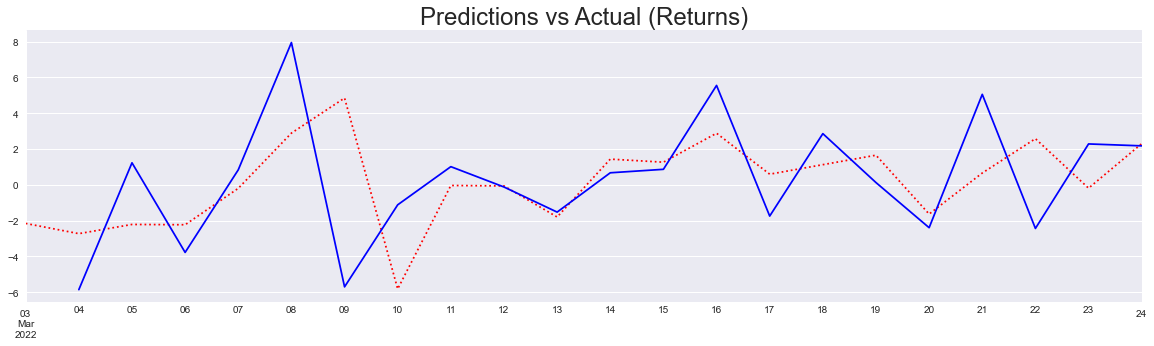

In [67]:
df_pred_armax = results_ret_armax.predict(start = start_date, end = end_date, exog = df_test.iloc[:, 1:][start_date:end_date]) 
df_pred_armax[start_date:end_date].plot(figsize = (20,5),linestyle='dotted', color = "red")
df_test.close[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [68]:
results_ret_armax.params

const          0.000072
EMA_S          0.094586
EMA_L         -0.048833
MACD           0.000356
MACD_Signal   -0.000203
vwap           0.944912
K              0.009707
D             -0.010952
SMA_L         -0.002979
SMA_S          0.009666
TH/s          -0.001326
NVDA           0.001369
LTC            0.005087
ETH           -0.002186
ar.L1.close   -0.009086
ma.L1.close   -0.998485
dtype: float64

In [69]:
results_ret_armax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  close   No. Observations:                 2025
Model:                     ARMA(1, 1)   Log Likelihood               -3378.479
Method:                       css-mle   S.D. of innovations              1.281
Date:                Thu, 24 Mar 2022   AIC                           6790.959
Time:                        17:13:50   BIC                           6886.385
Sample:                    08-17-2016   HQIC                          6825.975
                         - 03-03-2022                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        7.161e-05      0.000      0.183      0.855      -0.001       0.001
EMA_S           0.0946      0.041      2.309      0.021       0.014       0.175
EMA_L          -0.0488      0.056     -0.875      0.382      -0.158       0.061
MACD            0.0004      0.000      1.964      0.050    7.38e-07       0.001
MACD_Signal    -0.0002      0.000     -1.126      0.260      -0.001       0.000
vwap            0.9449      0.008    112.355      0.000       0.928       0.961
K               0.0097      0.001      9.935      0.000       0.008       0.012
D              -0.0110      0.001     -8.371      0.000      -0.014      -0.008
SMA_L          -0.0030      0.004     -0.814      0.416      -0.010       0.004
SMA_S           0.0097      0.020      0.484      0.629      -0.030       0.049
TH/s           -0.0013      0.001     -1.182      0.237      -0.004       0.001
NVDA            0.0014      0.002      0.784      0.433      -0.002       0.005
LTC             0.0051      0.002      3.300      0.001       0.002       0.008
ETH            -0.0022      0.001     -1.860      0.063      -0.004       0.000
ar.L1.close    -0.0091      0.023     -0.390      0.697      -0.055       0.037
ma.L1.close    -0.9985      0.003   -356.742      0.000      -1.004      -0.993
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1         -110.0581           +0.0000j          110.0581            0.5000
MA.1            1.0015           +0.0000j            1.0015            0.0000
-----------------------------------------------------------------------------
"""

### Auto ARIMA

In [70]:
model_auto = auto_arima(df.close, exogenous = df.iloc[:, 1:],m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5)

In [71]:
df_auto_pred = pd.DataFrame(model_auto.predict(n_periods = len(df_test[start_date:end_date]),
                            exogenous = df_test.iloc[:, 1:][start_date:end_date]),
                            index = df_test[start_date:end_date].index)

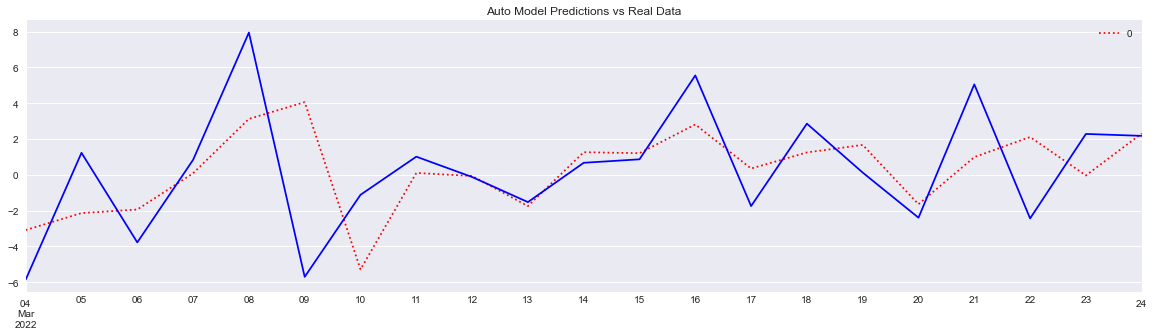

In [72]:
df_auto_pred.plot(figsize = (20,5), color = "red",linestyle='dotted')
df_test.close[start_date:end_date].plot(color = "blue")
plt.title("Auto Model Predictions vs Real Data")
plt.show()

In [73]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 2025
Model:             SARIMAX(2, 0, 2)x(1, 0, [], 5)   Log Likelihood               -3510.238
Date:                            Thu, 24 Mar 2022   AIC                           7060.476
Time:                                    17:16:44   BIC                           7172.743
Sample:                                08-17-2016   HQIC                          7101.672
                                     - 03-03-2022                                         
Covariance Type:                              opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -0.0102      0.010     -1.012      0.312      -0.030       0.010
EMA_S           0.5807      0.052     11.061      0.000       0.478       0.684
EMA_L          -0.8060      0.079    -10.195      0.000      -0.961      -0.651
MACD            0.0020      0.000      5.071      0.000       0.001       0.003
MACD_Signal     0.0006      0.000      1.214      0.225      -0.000       0.001
vwap            0.8535      0.008    105.301      0.000       0.838       0.869
K               0.0133      0.001     17.331      0.000       0.012       0.015
D              -0.0080      0.004     -2.199      0.028      -0.015      -0.001
SMA_L           0.0604      0.021      2.906      0.004       0.020       0.101
SMA_S           0.2793      0.032      8.691      0.000       0.216       0.342
TH/s           -0.0026      0.003     -0.905      0.366      -0.008       0.003
NVDA            0.0023      0.008      0.287      0.774      -0.014       0.018
LTC             0.0127      0.004      3.041      0.002       0.005       0.021
ETH             0.0182      0.004      4.854      0.000       0.011       0.026
ar.L1          -0.1180      0.357     -0.331      0.741      -0.818       0.581
ar.L2          -0.0652      0.031     -2.081      0.037      -0.127      -0.004
ma.L1          -0.6513      0.356     -1.830      0.067      -1.349       0.046
ma.L2          -0.0939      0.291     -0.322      0.747      -0.665       0.477
ar.S.L5        -0.0463      0.021     -2.249      0.025      -0.087      -0.006
sigma2          1.8506      0.033     56.550      0.000       1.786       1.915
===================================================================================
Ljung-Box (L1) (Q):                   3.26   Jarque-Bera (JB):              3370.34
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                             0.17
Prob(H) (two-sided):                  0.08   Kurtosis:                         9.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### SARIMAX

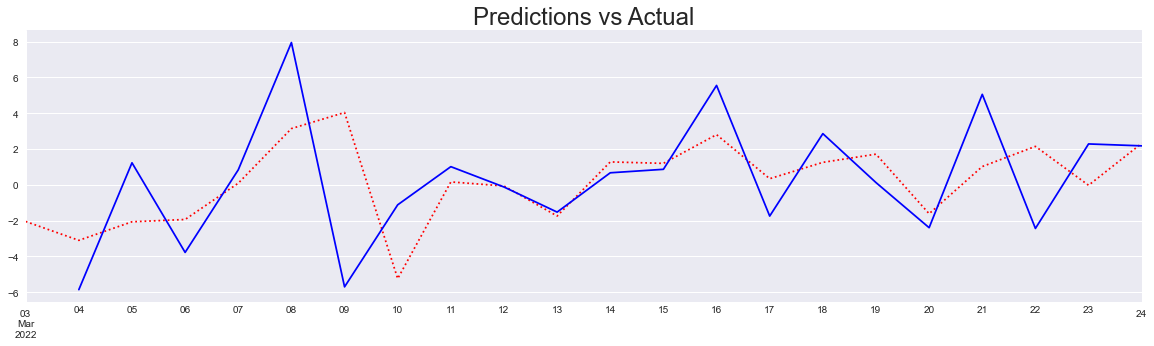

In [74]:
model_ret_sarimax = SARIMAX(df.close, exog = df.iloc[:, 1:], 
                            order = (2,0,2), seasonal_order = (1,0,0,5))
results_ret_sarimax = model_ret_sarimax.fit()

df_pred_sarimax = results_ret_sarimax.predict(start = start_date, end = end_date, 
                                              exog = df_test.iloc[:, 1:][start_date:end_date]) 

df_pred_sarimax[start_date:end_date].plot(figsize = (20,5), color = "red",linestyle='dotted')
df_test.close[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

In [75]:
results_ret_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              close   No. Observations:                 2025
Model:             SARIMAX(2, 0, 2)x(1, 0, [], 5)   Log Likelihood               -3511.328
Date:                            Thu, 24 Mar 2022   AIC                           7060.657
Time:                                    17:16:53   BIC                           7167.310
Sample:                                08-17-2016   HQIC                          7099.793
                                     - 03-03-2022                                         
Covariance Type:                              opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
EMA_S           0.5841      0.053     10.934      0.000       0.479       0.689
EMA_L          -0.8169      0.081    -10.132      0.000      -0.975      -0.659
MACD            0.0021      0.000      5.059      0.000       0.001       0.003
MACD_Signal     0.0004      0.000      0.765      0.444      -0.001       0.001
vwap            0.8500      0.008    103.412      0.000       0.834       0.866
K               0.0129      0.001     16.509      0.000       0.011       0.014
D              -0.0066      0.004     -1.746      0.081      -0.014       0.001
SMA_L           0.0636      0.020      3.235      0.001       0.025       0.102
SMA_S           0.2779      0.033      8.527      0.000       0.214       0.342
TH/s           -0.0029      0.003     -1.034      0.301      -0.009       0.003
NVDA            0.0009      0.008      0.107      0.914      -0.015       0.017
LTC             0.0223      0.004      5.564      0.000       0.014       0.030
ETH             0.0140      0.004      3.693      0.000       0.007       0.021
ar.L1          -0.1036      0.334     -0.310      0.757      -0.759       0.552
ar.L2          -0.0675      0.035     -1.951      0.051      -0.135       0.000
ma.L1          -0.6482      0.334     -1.944      0.052      -1.302       0.005
ma.L2          -0.0943      0.273     -0.345      0.730      -0.630       0.441
ar.S.L5        -0.0461      0.021     -2.242      0.025      -0.086      -0.006
sigma2          1.8592      0.033     56.528      0.000       1.795       1.924
===================================================================================
Ljung-Box (L1) (Q):                   5.29   Jarque-Bera (JB):              3281.26
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                             0.23
Prob(H) (two-sided):                  0.07   Kurtosis:                         9.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

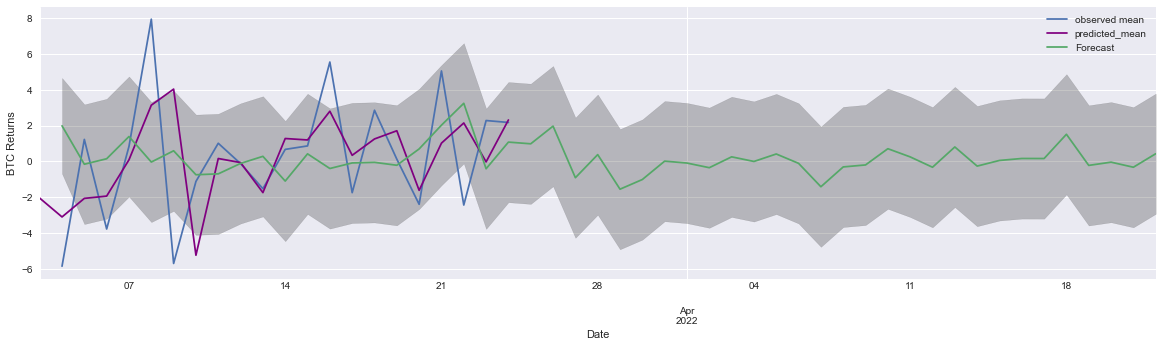

In [76]:
pred_uc = results_ret_sarimax.get_forecast(steps=50,signal_only=False,exog = df.iloc[:, 1:][:50])
pred_ci = pred_uc.conf_int()
ax = df_test.close.resample('D').mean().plot(label='observed mean', figsize=(14, 7))
ax = df_pred_sarimax[start_date:end_date].plot(figsize = (20,5), color = "purple")
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('BTC Returns')
plt.legend()
plt.show()

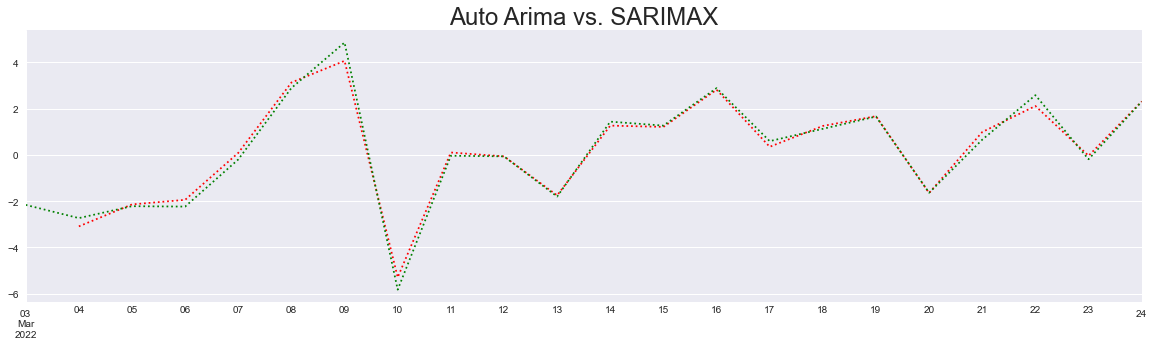

In [77]:
df_auto_pred.plot(figsize = (20,5), linestyle='dotted', color = "red",legend=None)
df_pred_armax[start_date:end_date].plot(linestyle='dotted', color = "green",legend=None)
plt.title("Auto Arima vs. SARIMAX", size = 24)
plt.legend = False
plt.show()

In [78]:
pred_ci.tail()

,lower close,upper close
2022-04-18,-1.845052,4.872647
2022-04-19,-3.584694,3.133005
2022-04-20,-3.404052,3.313646
2022-04-21,-3.687214,3.030484
2022-04-22,-2.932847,3.784852


In [79]:
newdf = pd.concat([pred_ci, df_test], axis=1)
newdf = newdf.rename(columns={"close": "returns","lower close": "lower returns","upper close": "upper returns"})
newdf2 = pd.concat([newdf, dfc['close']['2022-03-04':]], axis=1)
newdf2['Average Upper & Lower'] = newdf2[['lower returns', 'upper returns']].mean(axis=1)
newdf2.tail()

,lower returns,upper returns,returns,EMA_S,EMA_L,MACD,MACD_Signal,vwap,K,D,SMA_L,SMA_S,TH/s,NVDA,LTC,ETH,close,Average Upper & Lower
2022-04-18,-1.845052,4.872647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.513798
2022-04-19,-3.584694,3.133005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.225844
2022-04-20,-3.404052,3.313646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.045203
2022-04-21,-3.687214,3.030484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.328365
2022-04-22,-2.932847,3.784852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.426003


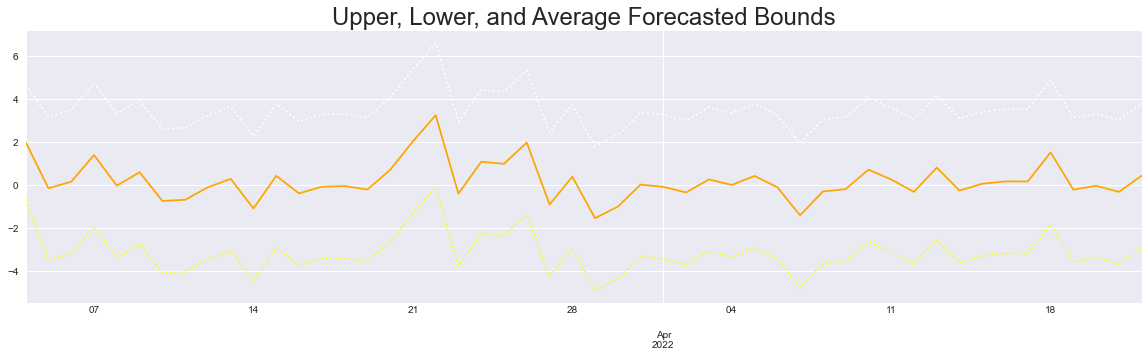

In [80]:
newdf2['lower returns'].plot(figsize = (20,5), linestyle='dotted', color = "yellow",legend=None)
newdf2['upper returns'].plot(linestyle='dotted', color = "white",legend=None)
newdf2['Average Upper & Lower'].plot(color = "orange",legend=None)
plt.style.use('dark_background')
plt.title("Upper, Lower, and Average Forecasted Bounds", size = 24)
plt.legend = False
plt.show()

In [81]:
# Pull in Future data
future = pd.read_csv("forecastdata.csv", parse_dates = ["Date"], index_col = "Date")
future.index = pd.to_datetime(future.index)
future.index = pd.to_datetime(future.index, format = '%m/%d/%Y').strftime('%Y-%m-%d')
future.tail()

,lower returns,upper returns,returns,EMA_S,EMA_L,MACD,MACD_Signal,vwap,K,D,SMA_L,SMA_S,TH/s,NVDA,LTC,ETH,close,Average Upper & Lower
Date,,,,,,,,,,,,,,,,,,
2022-04-18,-1.845052,4.872647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44391.66456,1.513798
2022-04-19,-3.584694,3.133005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44291.40849,-0.225844
2022-04-20,-3.404052,3.313646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44271.38746,-0.045203
2022-04-21,-3.687214,3.030484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44126.01566,-0.328365
2022-04-22,-2.932847,3.784852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44313.99369,0.426003


In [82]:
newdf3 = pd.concat([dfc['close'],future['close']['2022-03-25':]], axis=0)
newdf3.tail()

2022-04-18    44391.66456
2022-04-19    44291.40849
2022-04-20    44271.38746
2022-04-21    44126.01566
2022-04-22    44313.99369
Name: close, dtype: float64

### CONCLUSION

The current price of bitcoin is 43,882.90 USD as of 3/24/2022 4:39 PM EST. THe model predicts backing into prices from forecasted average log returns that on 4/22/2022 the price of bitcoin will be 44313.99 USD. Representing ~ 0.98% % upside.

Regardless of strategy it is apparent that draw down based on each strategy can be volatile, and it maybe benefical to implement more robust strategies, such as combining indicators, or utilizing an alternative strategy

Our models by review of their summary reveal that some of the exogenous factors may not be signficiant and may be removed to improve the modeling of our predictions and forecast

Utilizing an ' Auto - ARIMA' model to optimize the parameters provides us input for p,q,d as well as P,Q,D which can be fed into a SARIMAX model that may provide insight into the future trend of returns. WHile not directly tracking, near term movements may be reliable when reviewing forecasting data, as no model can account for countries adopting crypto